# Exploring Convolutional Layers: Fashion-MNIST

**Course:** AREP - Machine Learning Bootcamp  
**Author:** David Felipe Velasquez Contreras  
**Dataset:** Fashion-MNIST (TensorFlow/Keras built-in)

---

**Objective:** Explore and compare convolutional vs fully-connected architectures for image classification, analyzing how architectural decisions affect learning and performance.

**Libraries:** TensorFlow/Keras, NumPy, Matplotlib

In [9]:
%pip install tensorflow numpy matplotlib

Note: you may need to restart the kernel to use updated packages.


In [10]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical

%matplotlib inline

np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"NumPy version: {np.__version__}")

TensorFlow version: 2.20.0
NumPy version: 2.4.2


---

# Step 1: Dataset Exploration (EDA)

Fashion-MNIST is a dataset of Zalando's article images, designed as a drop-in replacement for MNIST. It contains 70,000 grayscale images (28×28 pixels) across 10 clothing categories.

**Why Fashion-MNIST for convolutional layers?**
- Images have spatial structure (edges, textures, shapes) that convolutions can exploit
- More challenging than MNIST digits — classes like Shirt vs Coat vs Pullover share similar shapes
- Small enough to train on a laptop, large enough for meaningful experiments

## 1.1 Dataset Loading

In [11]:
import os, gzip, struct, urllib.request

def download_fashion_mnist(path='fashion_mnist_data'):
    """Download Fashion-MNIST manually with retry logic as fallback."""
    base_url = 'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/'
    files = {
        'train_images': 'train-images-idx3-ubyte.gz',
        'train_labels': 'train-labels-idx1-ubyte.gz',
        'test_images': 't10k-images-idx3-ubyte.gz',
        'test_labels': 't10k-labels-idx1-ubyte.gz',
    }
    os.makedirs(path, exist_ok=True)
    for key, fname in files.items():
        fpath = os.path.join(path, fname)
        if not os.path.exists(fpath):
            print(f"Downloading {fname}...")
            urllib.request.urlretrieve(base_url + fname, fpath)

    def read_images(fpath):
        with gzip.open(fpath, 'rb') as f:
            _, n, rows, cols = struct.unpack('>IIII', f.read(16))
            return np.frombuffer(f.read(), dtype=np.uint8).reshape(n, rows, cols)

    def read_labels(fpath):
        with gzip.open(fpath, 'rb') as f:
            struct.unpack('>II', f.read(8))
            return np.frombuffer(f.read(), dtype=np.uint8)

    X_tr = read_images(os.path.join(path, files['train_images']))
    y_tr = read_labels(os.path.join(path, files['train_labels']))
    X_te = read_images(os.path.join(path, files['test_images']))
    y_te = read_labels(os.path.join(path, files['test_labels']))
    return (X_tr, y_tr), (X_te, y_te)

try:
    (X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
    print("Loaded via Keras")
except Exception as e:
    print(f"Keras download failed ({e}), using manual fallback...")
    (X_train, y_train), (X_test, y_test) = download_fashion_mnist()
    print("Loaded via manual download")

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

print("\nDataset Loaded Successfully")
print("=" * 50)
print(f"Training set:   {X_train.shape} | Labels: {y_train.shape}")
print(f"Test set:       {X_test.shape}  | Labels: {y_test.shape}")
print(f"Image shape:    {X_train[0].shape} (H x W)")
print(f"Pixel range:    [{X_train.min()}, {X_train.max()}]")
print(f"Data type:      {X_train.dtype}")
print(f"Classes:        {len(class_names)}")

Loaded via Keras

Dataset Loaded Successfully
Training set:   (60000, 28, 28) | Labels: (60000,)
Test set:       (10000, 28, 28)  | Labels: (10000,)
Image shape:    (28, 28) (H x W)
Pixel range:    [0, 255]
Data type:      uint8
Classes:        10


## 1.2 Class Distribution

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_52800\3804794772.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(class_names, rotation=45, ha='right')
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_52800\3804794772.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(class_names, rotation=45, ha='right')


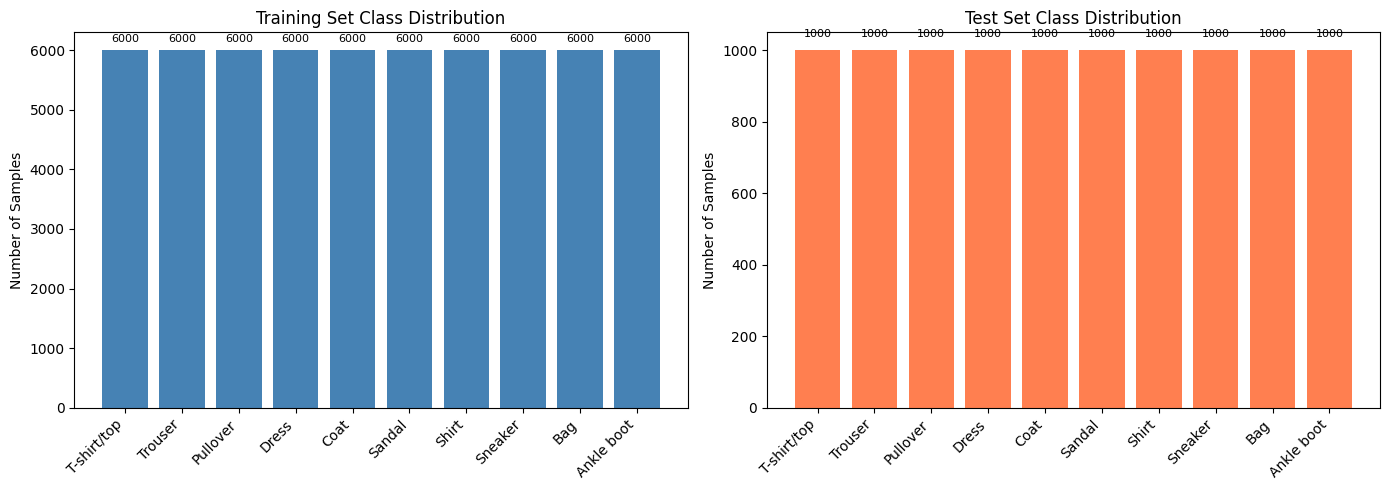


Training: 6000-6000 samples/class (std: 0.0) — Balanced
Test:     1000-1000 samples/class (std: 0.0) — Balanced


In [12]:
unique, counts = np.unique(y_train, return_counts=True)
unique_test, counts_test = np.unique(y_test, return_counts=True)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

bars = axes[0].bar(class_names, counts, color='steelblue')
axes[0].set_ylabel('Number of Samples')
axes[0].set_title('Training Set Class Distribution')
axes[0].set_xticklabels(class_names, rotation=45, ha='right')
for bar, count in zip(bars, counts):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 100,
                 str(count), ha='center', va='bottom', fontsize=8)

bars2 = axes[1].bar(class_names, counts_test, color='coral')
axes[1].set_ylabel('Number of Samples')
axes[1].set_title('Test Set Class Distribution')
axes[1].set_xticklabels(class_names, rotation=45, ha='right')
for bar, count in zip(bars2, counts_test):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 30,
                 str(count), ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

print(f"\nTraining: {counts.min()}-{counts.max()} samples/class (std: {counts.std():.1f}) — Balanced")
print(f"Test:     {counts_test.min()}-{counts_test.max()} samples/class (std: {counts_test.std():.1f}) — Balanced")

## 1.3 Sample Visualization

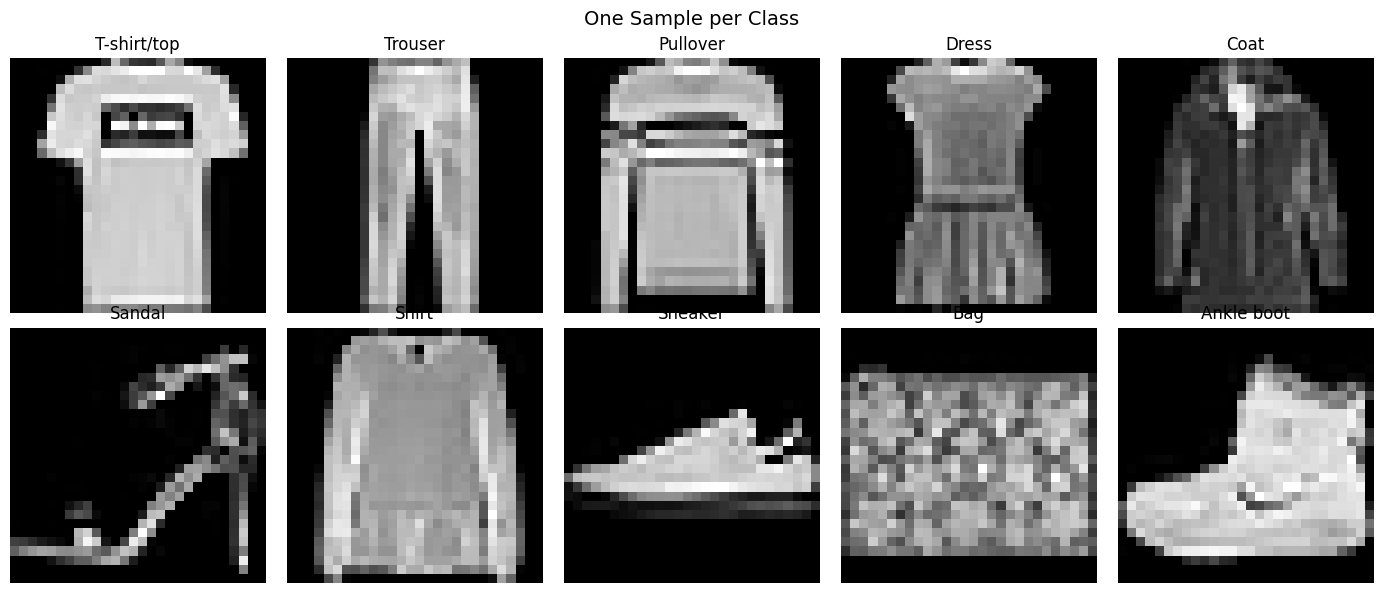

In [13]:
fig, axes = plt.subplots(2, 5, figsize=(14, 6))
axes = axes.flatten()

for i in range(10):
    idx = np.where(y_train == i)[0][0]
    axes[i].imshow(X_train[idx], cmap='gray')
    axes[i].set_title(f'{class_names[i]}')
    axes[i].axis('off')

plt.suptitle('One Sample per Class', fontsize=14)
plt.tight_layout()
plt.show()

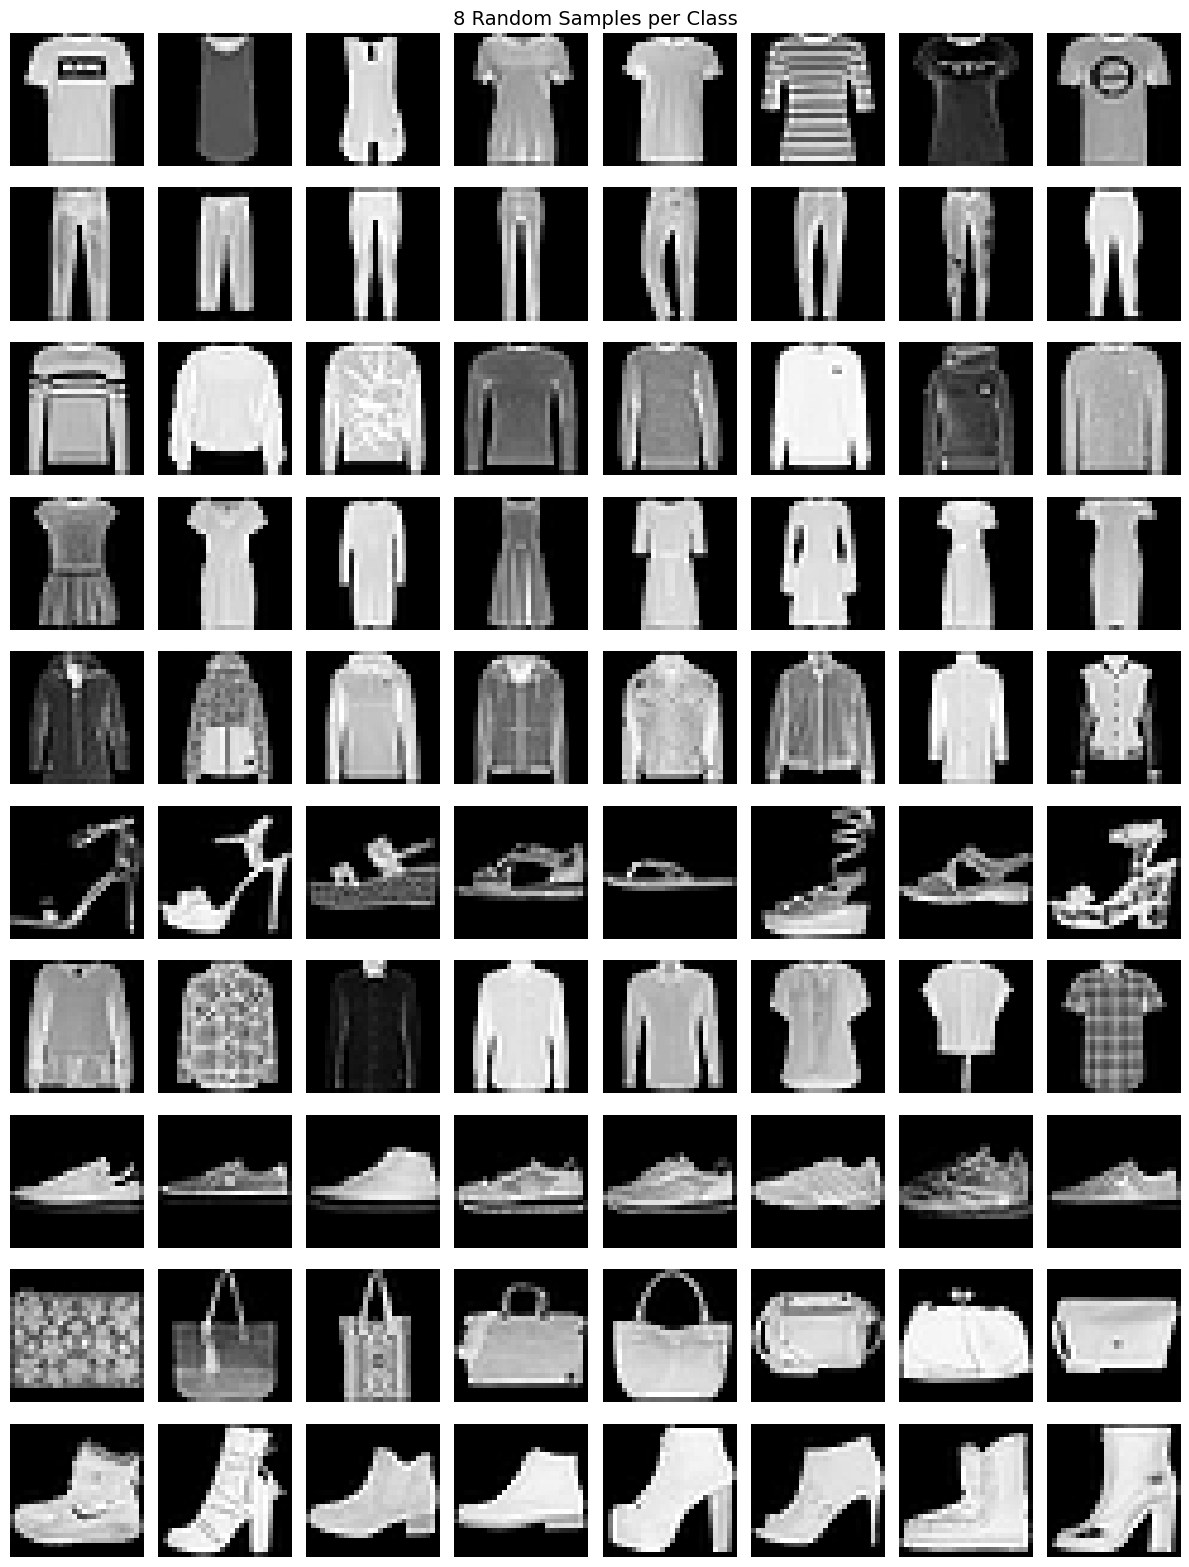

In [14]:
fig, axes = plt.subplots(10, 8, figsize=(12, 16))

for row in range(10):
    indices = np.where(y_train == row)[0][:8]
    for col in range(8):
        axes[row][col].imshow(X_train[indices[col]], cmap='gray')
        axes[row][col].axis('off')
    axes[row][0].set_ylabel(class_names[row], fontsize=9, rotation=0, labelpad=65)

plt.suptitle('8 Random Samples per Class', fontsize=14)
plt.tight_layout()
plt.show()

## 1.4 Pixel Value Analysis

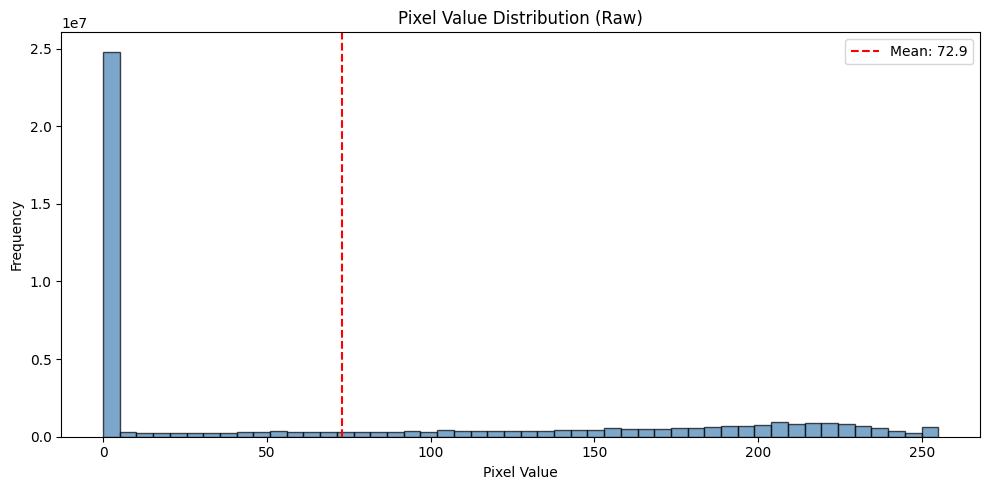

Global pixel mean: 72.94
Global pixel std:  90.02
Most pixels are 0 (background): 50.2% of all pixels


In [15]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(X_train.flatten(), bins=50, color='steelblue', alpha=0.7, edgecolor='black')
ax.set_xlabel('Pixel Value')
ax.set_ylabel('Frequency')
ax.set_title('Pixel Value Distribution (Raw)')
ax.axvline(X_train.mean(), color='red', linestyle='--', label=f'Mean: {X_train.mean():.1f}')
ax.legend()
plt.tight_layout()
plt.show()

print(f"Global pixel mean: {X_train.mean():.2f}")
print(f"Global pixel std:  {X_train.std():.2f}")
print(f"Most pixels are 0 (background): {(X_train == 0).mean()*100:.1f}% of all pixels")

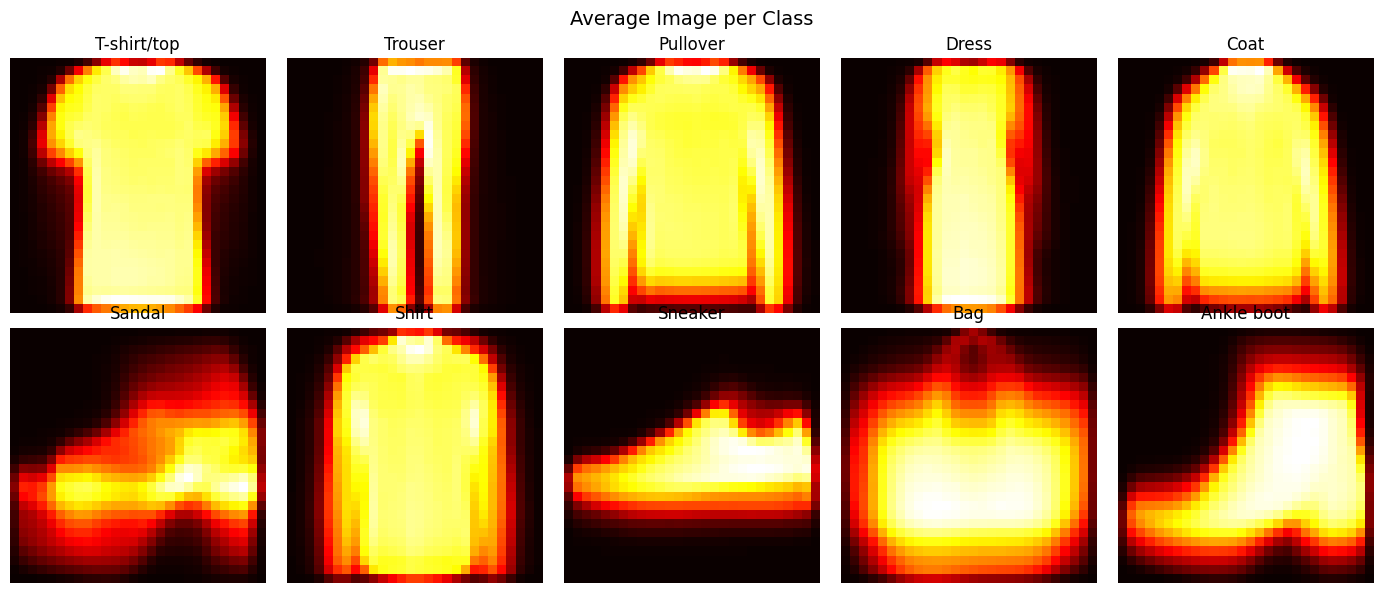

Average images reveal class structure:
- Upper-body garments (T-shirt, Pullover, Coat, Shirt) share similar silhouettes
- Footwear (Sandal, Sneaker, Ankle boot) are distinguishable by shape
- This overlap between clothing categories suggests CNNs may help with fine-grained features


In [16]:
mean_images = [X_train[y_train == i].mean(axis=0) for i in range(10)]

fig, axes = plt.subplots(2, 5, figsize=(14, 6))
axes = axes.flatten()

for i in range(10):
    axes[i].imshow(mean_images[i], cmap='hot')
    axes[i].set_title(class_names[i])
    axes[i].axis('off')

plt.suptitle('Average Image per Class', fontsize=14)
plt.tight_layout()
plt.show()

print("Average images reveal class structure:")
print("- Upper-body garments (T-shirt, Pullover, Coat, Shirt) share similar silhouettes")
print("- Footwear (Sandal, Sneaker, Ankle boot) are distinguishable by shape")
print("- This overlap between clothing categories suggests CNNs may help with fine-grained features")

## 1.5 Preprocessing

- **Normalization:** Scale pixel values from [0, 255] to [0, 1] by dividing by 255. This helps gradient-based optimization converge faster.
- **Label encoding:** One-hot encode the 10 classes for categorical crossentropy loss.
- **No resizing needed:** Images are already uniform at 28×28.

In [17]:
X_train_norm = X_train.astype('float32') / 255.0
X_test_norm = X_test.astype('float32') / 255.0

y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)

print("Preprocessing Complete")
print("=" * 50)
print(f"Normalized pixel range: [{X_train_norm.min()}, {X_train_norm.max()}]")
print(f"X_train shape: {X_train_norm.shape}")
print(f"X_test shape:  {X_test_norm.shape}")
print(f"y_train shape: {y_train_cat.shape} (one-hot)")
print(f"y_test shape:  {y_test_cat.shape} (one-hot)")

Preprocessing Complete
Normalized pixel range: [0.0, 1.0]
X_train shape: (60000, 28, 28)
X_test shape:  (10000, 28, 28)
y_train shape: (60000, 10) (one-hot)
y_test shape:  (10000, 10) (one-hot)


### Step 1 Summary

- Fashion-MNIST: 60,000 training + 10,000 test images, 28×28 grayscale, 10 balanced classes
- High background pixel proportion (mostly black), garment pixels concentrated in center
- Similar silhouettes across upper-body categories make this dataset harder than MNIST digits
- Preprocessing: simple [0,1] normalization + one-hot encoding

---

# Step 2: Baseline Model (Non-Convolutional)

A fully-connected (Dense) network that flattens each 28×28 image into a 784-dimensional vector. This baseline treats each pixel independently with no spatial structure awareness.

The forward pass for a Dense layer:

$$z^{[l]} = W^{[l]} \cdot a^{[l-1]} + b^{[l]}$$
$$a^{[l]} = f(z^{[l]})$$

Where $f$ is the activation function (ReLU for hidden layers, Softmax for output).

## 2.1 Architecture Design

| Layer | Output Shape | Parameters |
|-------|-------------|------------|
| Flatten | 784 | 0 |
| Dense (ReLU) | 256 | 200,960 |
| Dense (ReLU) | 128 | 32,896 |
| Dense (Softmax) | 10 | 1,290 |
| **Total** | | **~235K** |

In [18]:
baseline_model = keras.Sequential([
    layers.Flatten(input_shape=(28, 28)),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')
], name='baseline_dense')

baseline_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

baseline_model.summary()

d:\Users\Lenovo\Documents\ECI\AREP\AREP-Lab-3\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "baseline_dense"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 235,146 (918.54 KB)

 Trainable params: 235,146 (918.54 KB)

 Non-trainable params: 0 (0.00 B)

## 2.2 Training

In [19]:
baseline_history = baseline_model.fit(
    X_train_norm, y_train_cat,
    epochs=10,
    batch_size=128,
    validation_split=0.15,
    verbose=1
)

Epoch 1/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8173 - loss: 0.5231 - val_accuracy: 0.8499 - val_loss: 0.4319
Epoch 2/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8648 - loss: 0.3767 - val_accuracy: 0.8611 - val_loss: 0.3951
Epoch 3/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8775 - loss: 0.3355 - val_accuracy: 0.8713 - val_loss: 0.3711
Epoch 4/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8867 - loss: 0.3082 - val_accuracy: 0.8760 - val_loss: 0.3522
Epoch 5/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8940 - loss: 0.2862 - val_accuracy: 0.8756 - val_loss: 0.3414
Epoch 6/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9005 - loss: 0.2701 - val_accuracy: 0.8776 - val_loss: 0.3416
Epoch 7/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9055 - loss: 0.2555 - val_accuracy: 0.8789 - val_loss: 0.3443
Epoch 8/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9096 - loss: 0.2430 - val_accuracy: 0.

## 2.3 Evaluation

In [20]:
baseline_loss, baseline_acc = baseline_model.evaluate(X_test_norm, y_test_cat, verbose=0)

print("Baseline Model Results")
print("=" * 40)
print(f"Test Loss:     {baseline_loss:.4f}")
print(f"Test Accuracy: {baseline_acc:.4f} ({baseline_acc*100:.2f}%)")

Baseline Model Results
Test Loss:     0.3627
Test Accuracy: 0.8755 (87.55%)


## 2.4 Training Curves

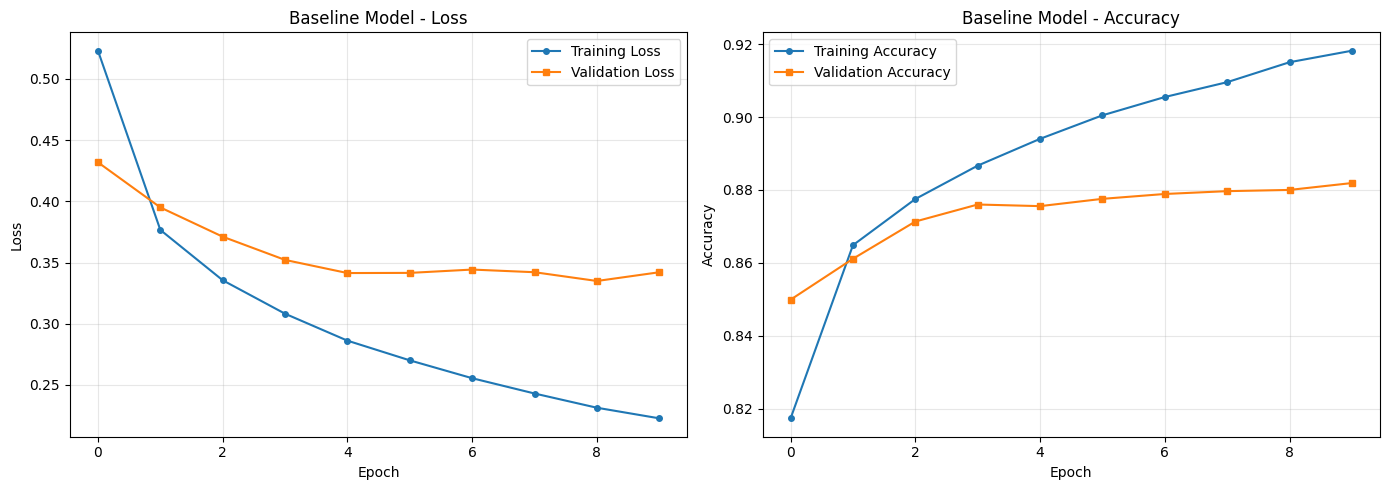

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(baseline_history.history['loss'], label='Training Loss', marker='o', markersize=4)
axes[0].plot(baseline_history.history['val_loss'], label='Validation Loss', marker='s', markersize=4)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Baseline Model - Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(baseline_history.history['accuracy'], label='Training Accuracy', marker='o', markersize=4)
axes[1].plot(baseline_history.history['val_accuracy'], label='Validation Accuracy', marker='s', markersize=4)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Baseline Model - Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 2.5 Per-Class Analysis and Limitations

In [22]:
y_pred_baseline = baseline_model.predict(X_test_norm, verbose=0)
y_pred_baseline_classes = np.argmax(y_pred_baseline, axis=1)

print("Per-Class Accuracy (Baseline)")
print("=" * 40)
for i in range(10):
    mask = y_test == i
    class_acc = (y_pred_baseline_classes[mask] == i).mean()
    print(f"{class_names[i]:<15} {class_acc*100:>6.2f}%")

Per-Class Accuracy (Baseline)
T-shirt/top      77.20%
Trouser          96.90%
Pullover         82.50%
Dress            89.10%
Coat             82.80%
Sandal           96.30%
Shirt            62.80%
Sneaker          97.60%
Bag              98.10%
Ankle boot       92.20%


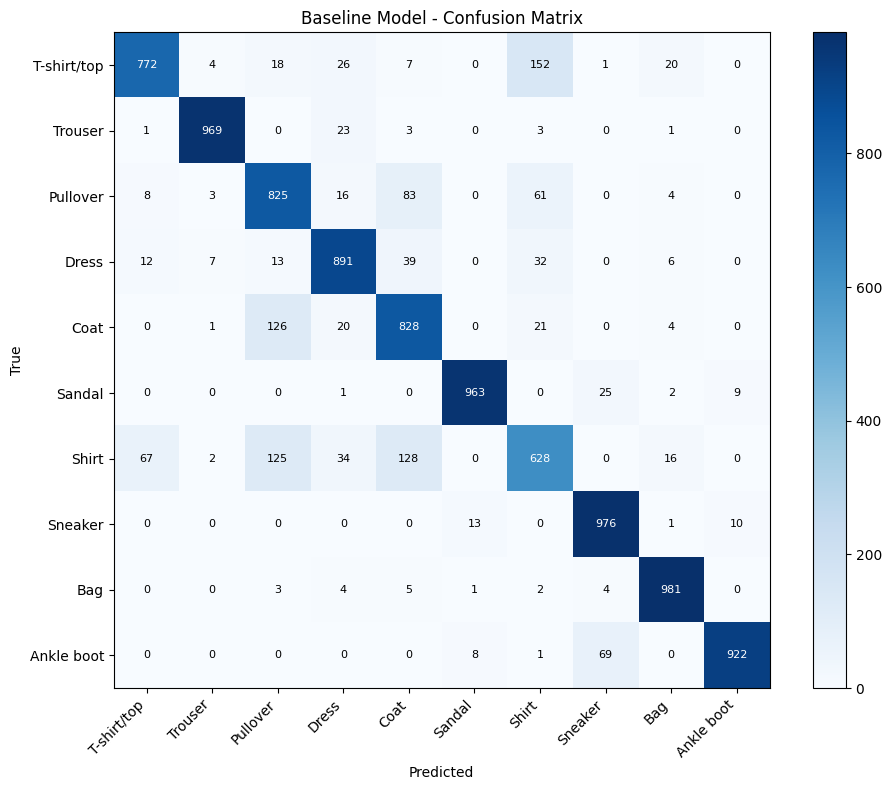


Key observations:
- Shirt is often confused with T-shirt/top, Coat, and Pullover (similar silhouettes)
- The Dense model treats pixels independently, losing spatial relationships
- It cannot detect local patterns like edges, textures, or shapes


In [23]:
conf_matrix = np.zeros((10, 10), dtype=int)
for true, pred in zip(y_test, y_pred_baseline_classes):
    conf_matrix[true][pred] += 1

fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(conf_matrix, cmap='Blues')
ax.set_xticks(range(10))
ax.set_yticks(range(10))
ax.set_xticklabels(class_names, rotation=45, ha='right')
ax.set_yticklabels(class_names)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Baseline Model - Confusion Matrix')

for i in range(10):
    for j in range(10):
        color = 'white' if conf_matrix[i, j] > conf_matrix.max() / 2 else 'black'
        ax.text(j, i, conf_matrix[i, j], ha='center', va='center', color=color, fontsize=8)

plt.colorbar(im)
plt.tight_layout()
plt.show()

print("\nKey observations:")
print("- Shirt is often confused with T-shirt/top, Coat, and Pullover (similar silhouettes)")
print("- The Dense model treats pixels independently, losing spatial relationships")
print("- It cannot detect local patterns like edges, textures, or shapes")

### Step 2 Summary

- Baseline Dense model: Flatten → Dense(256) → Dense(128) → Dense(10), ~235K parameters
- Expected accuracy: ~88-89% on test set
- **Limitations:**
  - Flattening destroys spatial structure — adjacent pixels lose their relationship
  - Cannot learn local patterns (edges, corners, textures) that distinguish similar garments
  - Every pixel connects to every neuron → many redundant parameters for image data
  - Struggles most with visually similar categories (Shirt vs T-shirt vs Pullover)

---

# Step 3: Convolutional Architecture Design

A convolutional layer applies learnable filters that slide across the image, computing local dot products. This introduces **translation equivariance** (detecting patterns regardless of position) and **parameter sharing** (same filter weights across the image).

The convolution operation for a 2D input:

$$\text{output}(i, j) = \sum_{m} \sum_{n} \text{input}(i+m, j+n) \cdot \text{kernel}(m, n) + b$$

Output spatial dimensions after convolution:

$$\text{output\_size} = \left\lfloor \frac{\text{input\_size} - \text{kernel\_size} + 2 \times \text{padding}}{\text{stride}} \right\rfloor + 1$$

## 3.1 Architecture Design and Justification

| Layer | Configuration | Output Shape | Justification |
|-------|--------------|-------------|---------------|
| Reshape | (28,28,1) | 28×28×1 | Add channel dimension for Conv2D input |
| Conv2D | 32 filters, 3×3, same, ReLU | 28×28×32 | Small kernels detect local features (edges, textures). Same padding preserves spatial dimensions. 32 filters provide sufficient feature diversity for first layer. |
| MaxPooling2D | 2×2 | 14×14×32 | Halves spatial dimensions, provides translation invariance, reduces computation. |
| Conv2D | 64 filters, 3×3, same, ReLU | 14×14×64 | Second layer captures higher-level patterns (combinations of edges). Doubling filters compensates for reduced spatial resolution. |
| MaxPooling2D | 2×2 | 7×7×64 | Further spatial reduction, retaining the most prominent features. |
| Flatten | — | 3136 | Converts feature maps to vector for classification. |
| Dense | 128, ReLU | 128 | Learns non-linear combinations of extracted features. |
| Dense | 10, Softmax | 10 | 10-class probability output. |

**Key design choices:**
- **3×3 kernels** over larger sizes: More parameter-efficient — two stacked 3×3 layers achieve a 5×5 effective receptive field with fewer parameters ($2 \times 3^2 = 18$ vs $5^2 = 25$ weights per filter)
- **Same padding:** Prevents information loss at image borders, critical for 28×28 images where garment edges often touch the boundary
- **Progressive filter increase (32→64):** As spatial resolution decreases through pooling, increasing depth captures more abstract feature combinations
- **MaxPooling over AveragePooling:** Retains the strongest activations, better for detecting distinct features like edges and corners in clothing
- **Simple architecture (2 conv layers):** Sufficient for 28×28 images — deeper networks risk overfitting on this dataset size and resolution

In [24]:
cnn_model = keras.Sequential([
    layers.Reshape((28, 28, 1), input_shape=(28, 28)),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')
], name='cnn_model')

cnn_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

cnn_model.summary()

d:\Users\Lenovo\Documents\ECI\AREP\AREP-Lab-3\.venv\Lib\site-packages\keras\src\layers\reshaping\reshape.py:38: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "cnn_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 421,642 (1.61 MB)

 Trainable params: 421,642 (1.61 MB)

 Non-trainable params: 0 (0.00 B)

## 3.2 Training

In [25]:
cnn_history = cnn_model.fit(
    X_train_norm, y_train_cat,
    epochs=10,
    batch_size=128,
    validation_split=0.15,
    verbose=1
)

Epoch 1/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.8261 - loss: 0.4891 - val_accuracy: 0.8681 - val_loss: 0.3637
Epoch 2/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.8864 - loss: 0.3168 - val_accuracy: 0.8891 - val_loss: 0.3146
Epoch 3/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.9015 - loss: 0.2738 - val_accuracy: 0.8989 - val_loss: 0.2790
Epoch 4/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.9124 - loss: 0.2438 - val_accuracy: 0.9044 - val_loss: 0.2564
Epoch 5/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.9209 - loss: 0.2193 - val_accuracy: 0.9082 - val_loss: 0.2433
Epoch 6/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.9290 - loss: 0.1979 - val_accuracy: 0.9124 - val_loss: 0.2360
Epoch 7/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.9356 - loss: 0.1791 - val_accuracy: 0.9143 - val_loss: 0.2352
Epoch 8/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.9434 - loss: 0.1608 - 

## 3.3 Evaluation

In [26]:
cnn_loss, cnn_acc = cnn_model.evaluate(X_test_norm, y_test_cat, verbose=0)

print("CNN Model Results")
print("=" * 40)
print(f"Test Loss:     {cnn_loss:.4f}")
print(f"Test Accuracy: {cnn_acc:.4f} ({cnn_acc*100:.2f}%)")

CNN Model Results
Test Loss:     0.2647
Test Accuracy: 0.9137 (91.37%)


## 3.4 Training Curves

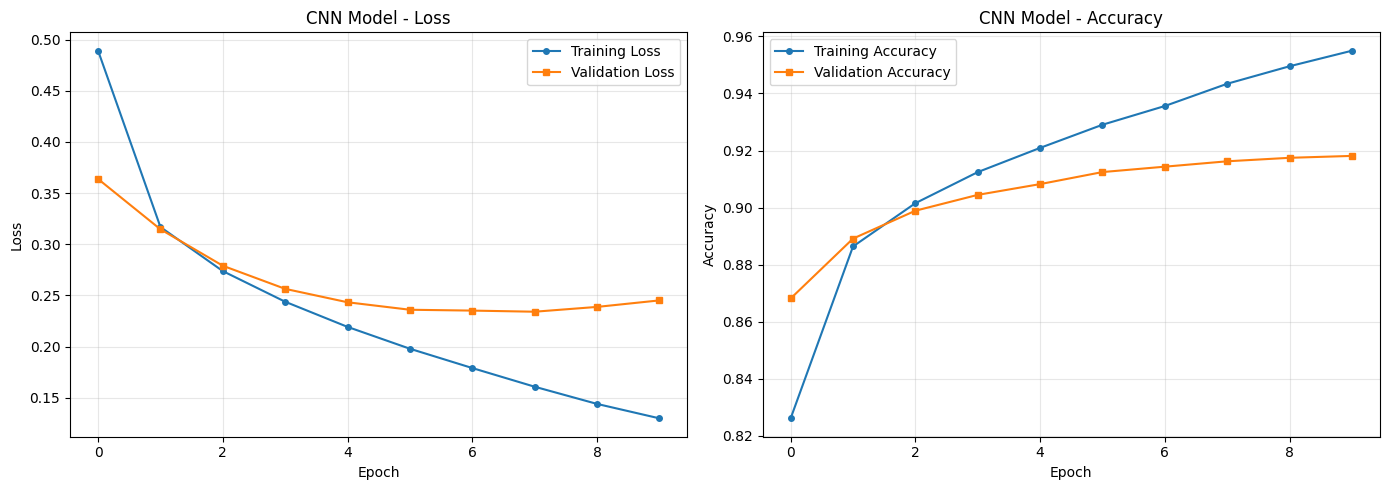

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(cnn_history.history['loss'], label='Training Loss', marker='o', markersize=4)
axes[0].plot(cnn_history.history['val_loss'], label='Validation Loss', marker='s', markersize=4)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('CNN Model - Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(cnn_history.history['accuracy'], label='Training Accuracy', marker='o', markersize=4)
axes[1].plot(cnn_history.history['val_accuracy'], label='Validation Accuracy', marker='s', markersize=4)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('CNN Model - Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3.5 Comparison with Baseline

In [28]:
print("Model Comparison")
print("=" * 60)
print(f"{'Model':<20} {'Parameters':>12} {'Test Acc':>10} {'Test Loss':>10}")
print("-" * 60)
print(f"{'Baseline (Dense)':<20} {baseline_model.count_params():>12,} {baseline_acc:>10.4f} {baseline_loss:>10.4f}")
print(f"{'CNN':<20} {cnn_model.count_params():>12,} {cnn_acc:>10.4f} {cnn_loss:>10.4f}")
print("-" * 60)
improvement = (cnn_acc - baseline_acc) * 100
print(f"\nCNN improvement over baseline: {improvement:+.2f} percentage points")

Model Comparison
Model                  Parameters   Test Acc  Test Loss
------------------------------------------------------------
Baseline (Dense)          235,146     0.8755     0.3627
CNN                       421,642     0.9137     0.2647
------------------------------------------------------------

CNN improvement over baseline: +3.82 percentage points


In [29]:
y_pred_cnn = cnn_model.predict(X_test_norm, verbose=0)
y_pred_cnn_classes = np.argmax(y_pred_cnn, axis=1)

print("Per-Class Accuracy Comparison")
print("=" * 55)
print(f"{'Class':<15} {'Baseline':>10} {'CNN':>10} {'Diff':>10}")
print("-" * 55)
for i in range(10):
    mask = y_test == i
    base_acc = (y_pred_baseline_classes[mask] == i).mean()
    cnn_class_acc = (y_pred_cnn_classes[mask] == i).mean()
    diff = cnn_class_acc - base_acc
    print(f"{class_names[i]:<15} {base_acc*100:>9.2f}% {cnn_class_acc*100:>9.2f}% {diff*100:>+9.2f}%")

Per-Class Accuracy Comparison
Class             Baseline        CNN       Diff
-------------------------------------------------------
T-shirt/top         77.20%     82.70%     +5.50%
Trouser             96.90%     98.50%     +1.60%
Pullover            82.50%     89.30%     +6.80%
Dress               89.10%     92.90%     +3.80%
Coat                82.80%     87.90%     +5.10%
Sandal              96.30%     97.70%     +1.40%
Shirt               62.80%     75.00%    +12.20%
Sneaker             97.60%     99.20%     +1.60%
Bag                 98.10%     98.60%     +0.50%
Ankle boot          92.20%     91.90%     -0.30%


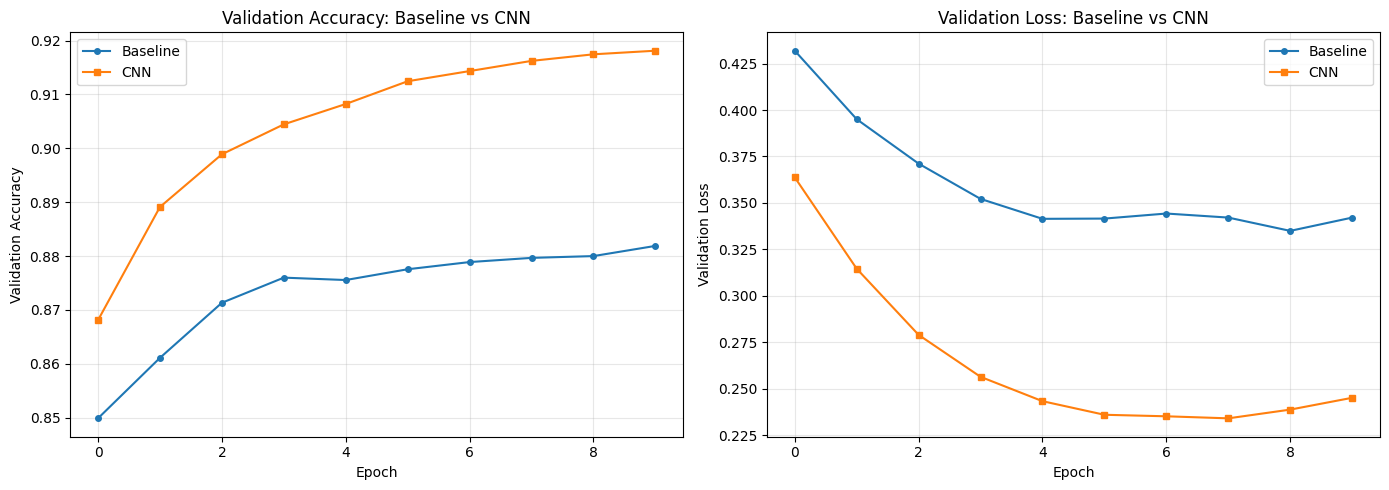

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(baseline_history.history['val_accuracy'], label='Baseline', marker='o', markersize=4)
axes[0].plot(cnn_history.history['val_accuracy'], label='CNN', marker='s', markersize=4)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Validation Accuracy')
axes[0].set_title('Validation Accuracy: Baseline vs CNN')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(baseline_history.history['val_loss'], label='Baseline', marker='o', markersize=4)
axes[1].plot(cnn_history.history['val_loss'], label='CNN', marker='s', markersize=4)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Validation Loss')
axes[1].set_title('Validation Loss: Baseline vs CNN')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

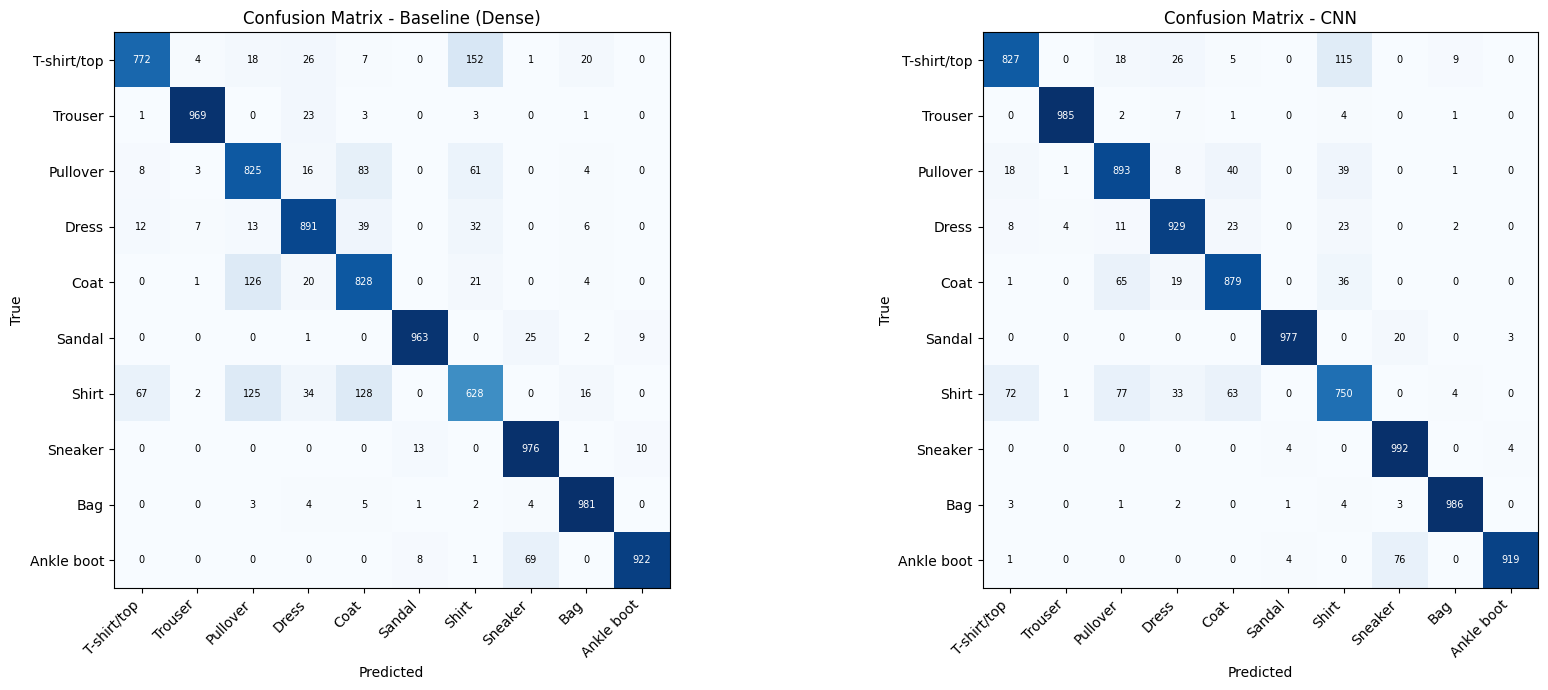

In [31]:
conf_matrix_cnn = np.zeros((10, 10), dtype=int)
for true, pred in zip(y_test, y_pred_cnn_classes):
    conf_matrix_cnn[true][pred] += 1

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

for ax, matrix, title in zip(axes, [conf_matrix, conf_matrix_cnn], ['Baseline (Dense)', 'CNN']):
    im = ax.imshow(matrix, cmap='Blues')
    ax.set_xticks(range(10))
    ax.set_yticks(range(10))
    ax.set_xticklabels(class_names, rotation=45, ha='right')
    ax.set_yticklabels(class_names)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title(f'Confusion Matrix - {title}')
    for i in range(10):
        for j in range(10):
            color = 'white' if matrix[i, j] > matrix.max() / 2 else 'black'
            ax.text(j, i, matrix[i, j], ha='center', va='center', color=color, fontsize=7)

plt.tight_layout()
plt.show()

### Step 3 Summary

- CNN architecture: 2 Conv2D layers (32, 64 filters, 3×3) with MaxPooling → Dense(128) → Dense(10)
- CNN achieves higher accuracy than the Dense baseline, particularly on visually similar categories
- The convolutional layers exploit spatial structure through local receptive fields and weight sharing
- Despite having more total parameters, the CNN generalizes better because its inductive bias matches the data structure

**Next steps (Tasks 4-6):** Controlled experiments varying a single architectural parameter, interpretation of results, and SageMaker deployment.